<a href="https://colab.research.google.com/github/jianxi-Erin/FruitClassifierVision/blob/main/model_train_predict_old.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 如没有数据集,运行此文件下载Fruits-360 数据集并解压
import os
import numpy as np
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from zipfile import ZipFile

# 数据集下载和解压
dataset_url = "https://github.com/Horea94/Fruit-Images-Dataset/archive/refs/heads/master.zip"
dataset_path = "fruits.zip"
if not os.path.exists(dataset_path):
    urlretrieve(dataset_url, dataset_path)
    with ZipFile(dataset_path, 'r') as zip_ref:
        zip_ref.extractall(".")
    os.rename("Fruit-Images-Dataset-master", "fruits")

In [12]:
# 基于cnn卷积神经网络的水果图片分类项目
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置中文字体
# 批大小
batch_size=32
# 是否使用cuda加速?,可选为cuda或者cpu
device="cuda"
# 学习率:学习率越大，参数更新的步长越大，但可能会导致训练不稳定；学习率越小，训练过程更稳定，但收敛速度可能会变慢。默认0.01
lr=0.001
# 定义训练周期:每个 Epoch 都会遍历一次完整的训练数据集。
Epoch=30

In [13]:
# 加载数据集
# 数据预处理

# 加载数据集
train_dataset = datasets.ImageFolder(
    root='fruits/Training',
    transform=transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),  # 随机水平翻转
    transforms.RandomRotation(degrees=10),  # 随机旋转（±10度）
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
)
test_dataset = datasets.ImageFolder(
    root='fruits/Test',
    transform=transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [14]:
# 定义cnn卷积神经网络模型
# CNN模型
class FruitCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # 特征提取部分
        self.features = nn.Sequential(
            # 第一层卷积
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 输入通道数为3（RGB图像），输出通道数为32
            nn.ReLU(),  # 激活函数，增加非线性
            nn.MaxPool2d(2),  # 最大池化，下采样，减少特征图的尺寸

            # 第二层卷积
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 输入通道数为32，输出通道数为64
            nn.ReLU(),  # 激活函数
            nn.MaxPool2d(2),  # 最大池化

            # 第三层卷积
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 输入通道数为64，输出通道数为128
            nn.ReLU(),  # 激活函数
            nn.MaxPool2d(2)  # 最大池化
        )
        # 分类器部分
        self.classifier = nn.Sequential(
            # 全连接层
            nn.Linear(128*8*8, 512),  # 输入特征数为128*8*8，输出特征数为512
            nn.ReLU(),  # 激活函数
            nn.Dropout(0.5),  # Dropout，随机丢弃50%的神经元，防止过拟合
            nn.Linear(512, num_classes)  # 输出层，输出特征数为类别数
        )

    def forward(self, x):
        # 前向传播
        x = self.features(x)  # 特征提取
        x = x.view(x.size(0), -1)  # 将特征图展平为一维向量
        return self.classifier(x)  # 分类

In [15]:
# 训练配置
if device == "cuda":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")
# 创建一个 FruitCNN 模型实例，并将其移动到指定的设备（GPU 或 CPU）
model = FruitCNN(num_classes=len(train_dataset.classes)).to(device)
# 定义损失函数，用于衡量模型预测值与真实标签之间的差异。
criterion = nn.CrossEntropyLoss()
# 定义优化器，用于更新模型的参数以最小化损失函数。
optimizer = optim.Adam(model.parameters(), lr=lr,weight_decay=1e-4)
# 定义学习率调度器，用于在训练过程中动态调整学习率。
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

Using device: cuda


In [10]:
# 训练模型


# 定义变量来跟踪最优性能
best_acc = 0.0  # 最优验证准确率
best_loss = float('inf')  # 最优验证损失（如果需要监控损失）

# 训练循环
for epoch in range(Epoch):  # 遍历指定的训练周期数
    model.train()  # 设置模型为训练模式
    running_loss = 0.0  # 初始化累计损失值

    # 遍历训练数据加载器，获取每个批次的数据
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # 将数据移动到指定设备
        optimizer.zero_grad()  # 清空优化器中的梯度
        outputs = model(images)  # 前向传播
        loss = criterion(outputs, labels)  # 计算损失值
        loss.backward()  # 反向传播
        optimizer.step()  # 更新模型参数
        running_loss += loss.item()  # 累加当前批次的损失值

    scheduler.step()  # 调整学习率

    # 验证阶段
    model.eval()  # 设置模型为评估模式
    correct = 0  # 初始化正确预测的数量
    total = 0  # 初始化总样本数量
    val_loss = 0.0  # 初始化验证损失

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # 将数据移动到指定设备
            outputs = model(images)  # 前向传播
            loss = criterion(outputs, labels)  # 计算验证损失
            val_loss += loss.item()  # 累加验证损失
            _, predicted = torch.max(outputs.data, 1)  # 获取预测类别
            total += labels.size(0)  # 累计总样本数量
            correct += (predicted == labels).sum().item()  # 累计正确预测的数量

    # 计算平均验证损失和准确率
    avg_val_loss = val_loss / len(test_loader)
    avg_val_acc = 100 * correct / total

    # 打印当前 Epoch 的平均训练损失和验证性能
    print(f"Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f} Val Loss: {avg_val_loss:.4f} Val Acc: {avg_val_acc:.2f}%")

    # 检查保存最优模型
    if avg_val_acc > best_acc:  # 如果当前 Epoch 的验证准确率更高
        best_acc = avg_val_acc  # 更新最优准确率
        torch.save(model.state_dict(), f"old_model/fruit_cnn_model_ValLoss_{avg_val_loss:.4f}_ValAcc_{best_acc:.3f}.pth")  # 保存最优模型参数
        print(f"Saved better model...")



Epoch 1 Loss: 0.1625 Val Loss: 0.2207 Val Acc: 95.54%
Saved better model...
Epoch 2 Loss: 0.1245 Val Loss: 0.1552 Val Acc: 96.09%
Saved better model...
Epoch 3 Loss: 0.0868 Val Loss: 0.1502 Val Acc: 96.56%
Saved better model...
Epoch 4 Loss: 0.0813 Val Loss: 0.1249 Val Acc: 96.78%
Saved better model...
Epoch 5 Loss: 0.0147 Val Loss: 0.0923 Val Acc: 98.11%
Saved better model...
Epoch 6 Loss: 0.0080 Val Loss: 0.0876 Val Acc: 98.17%
Saved better model...
Epoch 7 Loss: 0.0066 Val Loss: 0.0860 Val Acc: 98.18%
Saved better model...
Epoch 8 Loss: 0.0061 Val Loss: 0.0857 Val Acc: 97.98%
Epoch 9 Loss: 0.0062 Val Loss: 0.0880 Val Acc: 98.13%
Epoch 10 Loss: 0.0048 Val Loss: 0.0865 Val Acc: 98.21%
Saved better model...
Epoch 11 Loss: 0.0041 Val Loss: 0.0826 Val Acc: 98.26%
Saved better model...
Epoch 12 Loss: 0.0041 Val Loss: 0.0829 Val Acc: 98.34%
Saved better model...
Epoch 13 Loss: 0.0039 Val Loss: 0.0821 Val Acc: 98.29%
Epoch 14 Loss: 0.0035 Val Loss: 0.0823 Val Acc: 98.28%
Epoch 15 Loss: 0.00

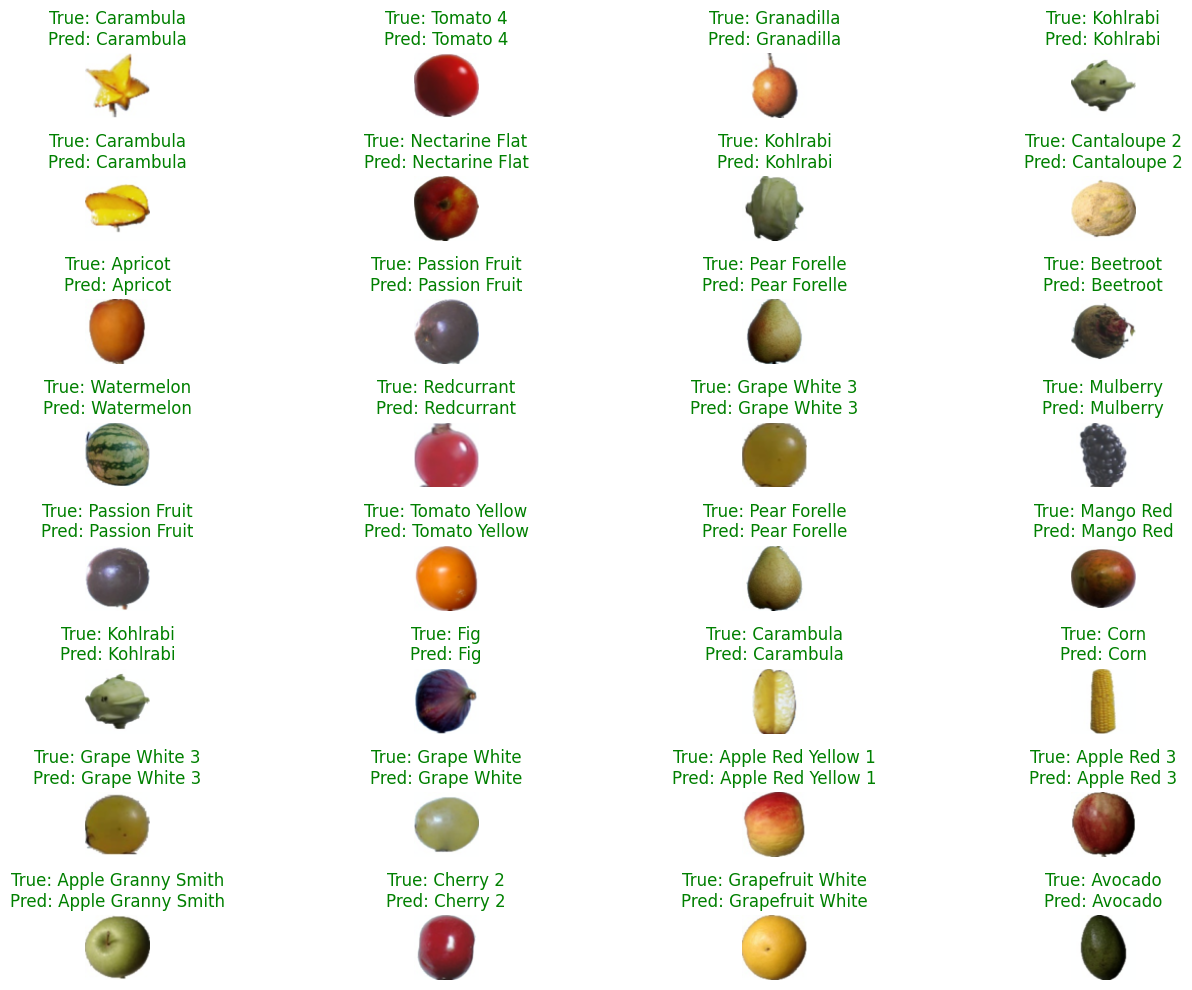

In [18]:
# 使用最优参数预测和可视化函数
# 加载标准模型
model = FruitCNN(num_classes=len(test_dataset.classes)).to(device)
# 加载最优模型参数
model.load_state_dict(torch.load("old_model/fruit_cnn_model_ValLoss_0.1278_ValAcc_98.003.pth", map_location=device))
# 设置模型为评估模式
model.eval()
# 预测和可视化函数
def visualize_predictions(test_loader, model, device, num_samples=32):
    # 获取一个批次的数据
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)

    # 进行预测
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # 转换图像为可显示格式
    images = images.cpu().numpy()
    images = images.transpose(0, 2, 3, 1)  # 从 (B, C, H, W) 转为 (B, H, W, C)

    # 反归一化
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    images = std * images + mean  # 反归一化
    images = np.clip(images, 0, 1)  # 限制像素值在0-1之间

    # 创建可视化
    plt.figure(figsize=(15, 10))
    for i in range(min(num_samples, len(images))):
        ax = plt.subplot(8, 4, i+1)
        plt.imshow(images[i])
        true_label = test_dataset.classes[labels[i].item()]
        pred_label = test_dataset.classes[preds[i].item()]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# 执行预测可视化
visualize_predictions(test_loader, model, device)